# Logical model of keratinocytes behavior as a respond to the cytokine environment at the chronic phase of psoriasis

<div class="alert alert-info">

**Note**
    
NB! This notebook was updated in Oct 2024, due to some syntax updates in pandas. Please run this version of the notebook if you encounter issues when running the queries. 

</div>  

This notebook is created for the analysis of psoriatic keratinocyte model presented in the "Logical and experimental modeling of cytokine and eicosanoid signaling in psoriatic keratinocyte" paper.

### Imports and model loading with GINsim
The first thing to do is to import the necessary tools for performing our analysis. (Plus, some settings to get nice-looking tables)

In [1]:
import ginsim 
import biolqm
import maboss
import pypint
from pypint import Goal #
from colomoto_jupyter import tabulate
from colomoto.temporal_logics import *
from itertools import combinations
from functools import reduce
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np
from pandas import DataFrame
import seaborn as sns

pd.set_option("display.max_rows", None, "display.max_columns", None)

This notebook has been executed using the docker image `colomoto/colomoto-docker:2022-07-01`

## The psoriatic keratinocytes logical model

The model represents the behavior of keratinocytes in the psoriatic microenvironment during the chronic phase of the disease. The microenvironment is dominated by Th17/22- and Th1-secreted cytokines, namely IL17, IL22, IFNg and TNFa. Additionally, the effect of PGE2, a cPLA2-derived proinflammatory lipid mediator, is modeled in the system through its action via EP2 and EP4 receptors. 

The model and consists of 88 nodes and 170 edges. In total, 38 nodes are used as markers to define the cell fate of keratinocyte (Survival/Proliferation, Apoptosis and Differentiation) and their involvement in maintaining and amplifying the Th17, Th22 and Th1 subpopulations in psoriatic lessions.

### Load and visualize network

In [41]:
gs_model = ginsim.load("psoKC_model.zginml")
print('The logical model of keratinocytes during chronic phase of psoriasis.')
ginsim.show(gs_model)

The logical model of keratinocytes during chronic phase of psoriasis.


Convert model to the necessary formats for further analysis:

In [3]:
# Convert ginsim model to a biolqm, maboss and pint compliant models 
lqm_model = ginsim.to_biolqm(gs_model)
mbs_model = ginsim.to_maboss(gs_model)
pint_model = biolqm.to_pint(lqm_model)

Acquire a summary of general model properties with Pint:

In [4]:
pint_model.summary()

{'nb_automata': 88,
 'nb_local_states': 176,
 'max_local_states': 2,
 'nb_transitions': 267,
 'nb_states': 309485009821345068724781056}

## Node-phenotype associations

The model contain 18 marker nodes associated with the three deregulated phenotypes of psoriatic keratinocytes: proliferation, differentiation and apoptosis. Additionally, 23 marker nodes are associated with the recruitment, activation and maintenance of three subpopulations of immune cells: Th1, Th17/22 and other immune cells, mainly referring to Neutrophils. The association between nodes and phenotypes are presented in the following table:

In [5]:
Node_phenotype = {"Node": [ 'CCND1','IL8', 'IL19', 'PGE2', 'HETE12', 'PPARD', 'HBEGF', 'CFLAR', 'BCL2','CREB1','BAD', 'CASP8','FOXO3', 'FLG', 'KRT1', 'CALML5', 'SIRT1', 'CDKN1A', 'IL6', 'CCL7', 'CXCL1', 'CXCL2', 'CXCL5', 'LTB4', 'CSF3', 'S100A7',  'S100A8', 'S100A9',  'DEFB4A', 'EP2_g', 'EP4_g', 'CXCL3', 'IFNG', 'IL12', 'IL23', 'IL36', 'IL1B', 'TNFa', 'CCL2', 'CCL5', 'CCL20'], 
                  "Main Phenotype": [ 'Proliferation','Proliferation', 'Proliferation', 'Proliferation', 'Proliferation', 'Proliferation', 'Proliferation', 'Survival','Survival', 'Survival', 'Apoptosis','Apoptosis', 'Apoptosis', 'Differentiation', 'Differentiation', 'Differentiation', 'Differentiation', 'Differentiation', 'Immune cells', 'Immune cells', 'Immune cells', 'Immune cells', 'Immune cells', 'Immune cells', 'Immune cells', 'Inflammation', 'Inflammation', 'Inflammation','Inflammation', 'Inflammation', 'Inflammation ','Th1', 'Th1', 'Th1', 'Th17/22', 'Th17/22', 'Th17/22', 'Th17/22', 'Th17/22', 'Th17/22', 'Th17/22']}

df_phen = pd.DataFrame(data=Node_phenotype)
df_phen.style.hide_index()

/tmp/ipykernel_885/1887982090.py:5: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  df_phen.style.hide_index()


Node,Main Phenotype
CCND1,Proliferation
IL8,Proliferation
IL19,Proliferation
PGE2,Proliferation
HETE12,Proliferation
PPARD,Proliferation
HBEGF,Proliferation
CFLAR,Survival
BCL2,Survival
CREB1,Survival


## Identification of attractors (bioLQM)

In [6]:
# Define input conditions
inpTH17 = ('IL22R == 1 & IL17R == 1 & TNFRSF1A == 0 & IFNGR == 0 & EP4 == 1 & EP2 == 1 & EP1 == 0 & EP3 == 0 & VDR == 0')
inpTH1 = ('IL22R == 0 & IL17R == 0 & TNFRSF1A == 1 & IFNGR == 1 & EP4 == 1 & EP2 == 1 &  EP1 == 0 & EP3 == 0 & VDR == 0')
inpALL = ('IL22R == 1 & IL17R == 1 & TNFRSF1A == 1 & IFNGR == 1 & EP4 == 1  & EP2 == 1 & EP1 == 0 & EP3 == 0 & VDR == 0')
inpALL_EP1 = ('IL22R == 1 & IL17R == 1 & TNFRSF1A == 1 & IFNGR == 1 & EP4 == 0  & EP2 == 1 & EP1 == 1 & EP3 == 0 & VDR == 0')
inpALL_EP2 = ('IL22R == 1 & IL17R == 1 & TNFRSF1A == 1 & IFNGR == 1 & EP4 == 0  & EP2 == 1 & EP1 == 0 & EP3 == 0 & VDR == 0')
inpALL_EP3 = ('IL22R == 1 & IL17R == 1 & TNFRSF1A == 1 & IFNGR == 1 & EP4 == 0  & EP2 == 0 & EP1 == 0 & EP3 == 1 & VDR == 0')
inpALL_EP4 = ('IL22R == 1 & IL17R == 1 & TNFRSF1A == 1 & IFNGR == 1 & EP4 == 1  & EP2 == 0 & EP1 == 0 & EP3 == 0 & VDR == 0')
inpALL_noEP = ('IL22R == 1 & IL17R == 1 & TNFRSF1A == 1 & IFNGR == 1 & EP4 == 0  & EP2 == 0 & EP1 == 0 & EP3 == 0 & VDR == 0')

#Prepare indexes with only the output nodes
markers = ['BAD', 'CASP8', 'FOXO3', 'CFLAR', 'BCL2', 'CCND1', 'CREB1','IL8', 'IL19', 'PGE2', 'HETE12', 'PPARD', 'HBEGF', 'FLG', 'KRT1', 'CALML5', 'SIRT1', 'CDKN1A', 'IL6', 'CCL7', 'CXCL1', 'CXCL2', 'CXCL5', 'LTB4', 'CSF3', 'S100A7',  'S100A8', 'S100A9',  'DEFB4A', 'EP2_g', 'EP4_g', 'CXCL3', 'IFNG', 'IL12', 'IL23', 'IL36', 'IL1B', 'TNFa', 'CCL2', 'CCL5', 'CCL20']

phen_arrays = [['Apoptosis', 'Apoptosis', 'Apoptosis', 'Survival', 'Survival', 'Survival', 'Proliferation','Proliferation', 'Proliferation', 'Proliferation', 'Proliferation', 'Proliferation', 'Proliferation',  'Differentiation', 'Differentiation', 'Differentiation', 'Differentiation', 'Differentiation', 'Immune cells', 'Immune cells', 'Immune cells', 'Immune cells', 'Immune cells', 'Immune cells', 'Immune cells', 'Inflammation', 'Inflammation', 'Inflammation','Inflammation', 'Inflammation', 'Inflammation', 'Th1', 'Th1', 'Th1', 'Th17/22', 'Th17/22', 'Th17/22', 'Th17/22', 'Th17/22', 'Th17/22', 'Th17/22'],
               markers]

infl_markers = ['IL6', 'CCL7', 'CXCL1', 'CXCL2', 'CXCL5', 'LTB4', 'CSF3', 'S100A7',  'S100A8', 'S100A9',  'DEFB4A','cPLA2a', 'EP2_g', 'EP4_g', 'CXCL3', 'IFNG', 'IL12', 'IL23', 'IL36', 'IL1B', 'TNFa', 'CCL2', 'CCL5', 'CCL20']
fate_markers = ['CCND1','IL8', 'IL19', 'PPARD', 'HBEGF', 'CFLAR', 'BCL2','CREB1','BAD', 'CASP8','FOXO3']

In [7]:
# Compute stable states
fixpoints = biolqm.fixpoints(lqm_model)
fix_df = pd.DataFrame(fixpoints)
tabulate(fixpoints)

# Uncomment to save stable states as a csv
# fix_df.to_csv('fixpoints.csv')

,TNFRSF1A,TRAF6,TAK1,IKBKB,NFKBIA,NFKBIZ,IKBKG,NFKB,TNFAIP3,P38,ERK1_2,JNK,MNK1,PIK3R1,PDPK1,AKT,PRKCA,AP1,CREB1,PLCG1,PRKACA,RIPK1,TRADD,TRAF2,FADD,CASP8,CFLAR,IL8,IL6,BAD,BCL2,CDKN1A,CCND1,IFNGR,STAT1,IL36,IL17R,CEBP,IL19,IL22R,STAT3,SOCS3,SOCS1,SIRT1,AA,cPLA2a,COX2,PGE2,EP2,EP4,PGI2,EGR1,ALOX5,LTB4,SP1,ALOX12,HETE12,PPARD,TRAF3IP2,KRT1,FLG,CALML5,CXCL3,IFNG,IL12,TNFa,IL1B,CCL2,CCL5,CCL20,CXCL1,CXCL2,CXCL5,EGFR,VDR,EP2_g,EP4_g,S100A7,S100A8,S100A9,DEFB4A,HBEGF,CSF3,CCL7,FOXO3,IL23,EP1,EP3
0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1
5,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1
6,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1
7,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1
9,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1
8,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1


#### Testing the hypothesis of the role of EP4-dependent signaling in keratinocyte behavior in psoriasis.

Figure 2. Predicted states with active and inactive EP4 receptor


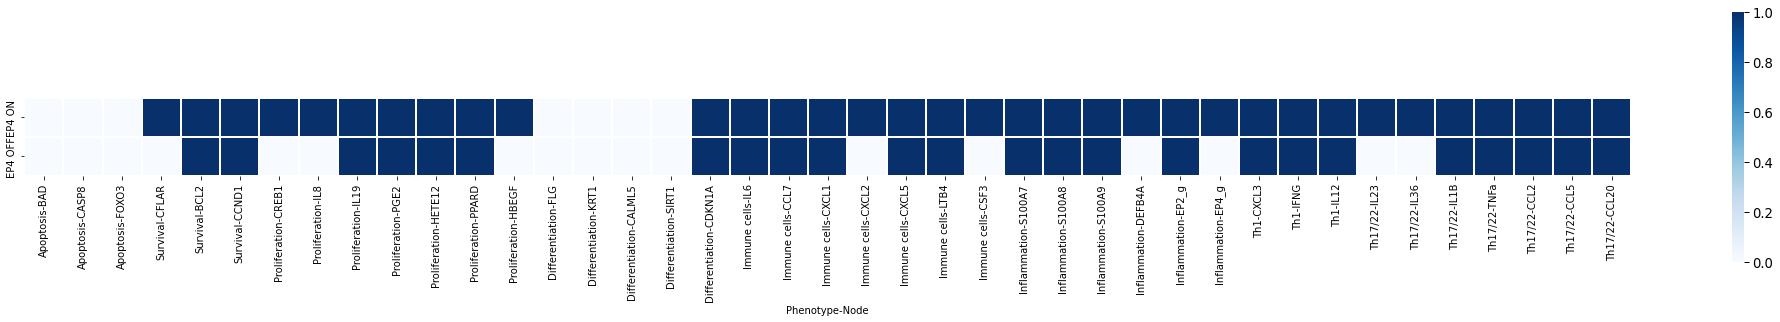

In [8]:
# Set initial states
# Select only output nodes to show
# Create a multilevel index with phenotypes

ALL_EP4_fp = fix_df.query(inpALL_EP4) 
ALL_EP4_fp = ALL_EP4_fp[markers] 
ALL_EP4_fp.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])

noEP = fix_df.query(inpALL_noEP) 
noEP = noEP[markers] 
noEP.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])

frames = [ALL_EP4_fp,noEP]
all_EP_results = pd.concat(frames, keys=["EP4 ON","EP4 OFF"] )
all_EP_results.index = all_EP_results.index.droplevel(1)

print("Figure 2. Predicted states with active and inactive EP4 receptor")
fig, ax = plt.subplots(figsize=(36, 46))
sns.set_context("paper", font_scale=1.5)

f = sns.heatmap(all_EP_results, cmap = "Blues", square = True, linewidth=0.3, cbar_kws={"shrink": .1})
#plt.show()
#f.figure.savefig('simulations_EP4.png')

#### Predictions of the keratinocyte behavior in response to various inputs
The following code defines the input conditions of interest (Th17/22 cytokines + EP4, Th1 cytokines + EP4, All cytokines + EP4) and shows only the state of the markers.

In [9]:
# Set initial states
# Select only output nodes to show
# Create a multilevel index with phenotypes
# Show prediction results for the defined input

TH17_fp = fix_df.query(inpTH17) 
TH17_fp = TH17_fp[markers] 
TH17_fp.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])

TH17_fp

Phenotype Apoptosis             Survival            Proliferation           \
Node            BAD CASP8 FOXO3    CFLAR BCL2 CCND1         CREB1 IL8 IL19   
149               0     0     0        1    1     1             1   1    1   

Phenotype                         Differentiation                           \
Node      PGE2 HETE12 PPARD HBEGF             FLG KRT1 CALML5 SIRT1 CDKN1A   
149          1      0     1     1               0    0      0     1      1   

Phenotype Immune cells                                  Inflammation         \
Node               IL6 CCL7 CXCL1 CXCL2 CXCL5 LTB4 CSF3       S100A7 S100A8   
149                  1    0     1     1     1    0    1            1      1   

Phenotype                             Th1           Th17/22                 \
Node      S100A9 DEFB4A EP2_g EP4_g CXCL3 IFNG IL12    IL23 IL36 IL1B TNFa   
149            1      1     0     1     1    0    0       1    1    1    1   

Phenotype                  
Node      CCL2 CCL5 CCL20  
149          1    1     1

In [10]:
TH17_fp = fix_df.query(inpTH17) 
TH17_fp

,TNFRSF1A,TRAF6,TAK1,IKBKB,NFKBIA,NFKBIZ,IKBKG,NFKB,TNFAIP3,P38,ERK1_2,JNK,MNK1,PIK3R1,PDPK1,AKT,PRKCA,AP1,CREB1,PLCG1,PRKACA,RIPK1,TRADD,TRAF2,FADD,CASP8,CFLAR,IL8,IL6,BAD,BCL2,CDKN1A,CCND1,IFNGR,STAT1,IL36,IL17R,CEBP,IL19,IL22R,STAT3,SOCS3,SOCS1,SIRT1,AA,cPLA2a,COX2,PGE2,EP2,EP4,PGI2,EGR1,ALOX5,LTB4,SP1,ALOX12,HETE12,PPARD,TRAF3IP2,KRT1,FLG,CALML5,CXCL3,IFNG,IL12,TNFa,IL1B,CCL2,CCL5,CCL20,CXCL1,CXCL2,CXCL5,EGFR,VDR,EP2_g,EP4_g,S100A7,S100A8,S100A9,DEFB4A,HBEGF,CSF3,CCL7,FOXO3,IL23,EP1,EP3
149,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,0,1,0,0


In [11]:
TH1_fp = fix_df.query(inpTH1) 
TH1_fp = TH1_fp[markers] 
TH1_fp.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])

TH1_fp

Phenotype Apoptosis             Survival            Proliferation           \
Node            BAD CASP8 FOXO3    CFLAR BCL2 CCND1         CREB1 IL8 IL19   
287               0     0     0        1    1     1             1   1    0   

Phenotype                         Differentiation                           \
Node      PGE2 HETE12 PPARD HBEGF             FLG KRT1 CALML5 SIRT1 CDKN1A   
287          1      1     1     1               0    1      1     0      1   

Phenotype Immune cells                                  Inflammation         \
Node               IL6 CCL7 CXCL1 CXCL2 CXCL5 LTB4 CSF3       S100A7 S100A8   
287                  1    1     1     1     1    1    0            1      1   

Phenotype                             Th1           Th17/22                 \
Node      S100A9 DEFB4A EP2_g EP4_g CXCL3 IFNG IL12    IL23 IL36 IL1B TNFa   
287            1      0     1     1     1    1    1       1    1    1    1   

Phenotype                  
Node      CCL2 CCL5 CCL20  
287          1    1     1

In [12]:
ALL_fp = fix_df.query(inpALL) 
ALL_fp = ALL_fp[markers] 
ALL_fp.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])

ALL_fp

Phenotype Apoptosis             Survival            Proliferation           \
Node            BAD CASP8 FOXO3    CFLAR BCL2 CCND1         CREB1 IL8 IL19   
421               0     0     0        1    1     1             1   1    1   

Phenotype                         Differentiation                           \
Node      PGE2 HETE12 PPARD HBEGF             FLG KRT1 CALML5 SIRT1 CDKN1A   
421          1      1     1     1               0    0      0     0      1   

Phenotype Immune cells                                  Inflammation         \
Node               IL6 CCL7 CXCL1 CXCL2 CXCL5 LTB4 CSF3       S100A7 S100A8   
421                  1    1     1     1     1    1    1            1      1   

Phenotype                             Th1           Th17/22                 \
Node      S100A9 DEFB4A EP2_g EP4_g CXCL3 IFNG IL12    IL23 IL36 IL1B TNFa   
421            1      1     1     1     1    1    1       1    1    1    1   

Phenotype                  
Node      CCL2 CCL5 CCL20  
421          1    1     1

## Perturbation analysis

In [13]:
# Define perturbations and inputs
AVX = biolqm.perturbation(lqm_model, 'cPLA2a%0 VDR%0 EP4%0 EP2%0 EP1%0 EP3%0')
CAL = biolqm.perturbation(lqm_model, 'VDR%1 EP4%1 EP2%1 EP1%0 EP3%0')
COM = biolqm.perturbation(lqm_model, 'cPLA2a%0 VDR%1 EP4%0 EP2%0 EP1%0 EP3%0')

# Redefine initial states without defining the state of VDR and EP receptors
pTH17 = ('IL22R == 1 & IL17R == 1 & TNFRSF1A == 0 & IFNGR == 0')
pTH1 = ('IL22R == 0 & IL17R == 0 & TNFRSF1A == 1 & IFNGR == 1')
pALL = ('IL22R == 1 & IL17R == 1 & TNFRSF1A == 1 & IFNGR == 1')

The following code performs perturbation simulations in all three conditions (TH17/22, TH1 and ALL). 
The perturbations performed are the following:

- AVX: Inhibition of cPLA2
- CAL: Activation of VDR receptor
- COMBO: Combination of AVX and CAL

In [14]:
# Identify all stable states (or trapspaces for certain conditions)
AVX_fps = biolqm.fixpoints(AVX)
AVX_fps_df = pd.DataFrame(AVX_fps)

CAL_fps = biolqm.fixpoints(CAL)
CAL_fps_df = pd.DataFrame(CAL_fps)

COM_fps = biolqm.fixpoints(COM)
COM_fps_df = pd.DataFrame(COM_fps)

In [15]:
# Perform perturbation analysis for Th17 cytokines
AVX_TH17_fp = AVX_fps_df.query(pTH17) 
AVX_TH17 = AVX_TH17_fp[markers] 
AVX_TH17.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])
AVX_TH17_df = pd.DataFrame(AVX_TH17)
 
CAL_TH17_fp = CAL_fps_df.query(pTH17) 
CAL_TH17 = CAL_TH17_fp[markers] 
CAL_TH17.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])
CAL_TH17_df = pd.DataFrame(CAL_TH17)

COMBO_TH17_fp = COM_fps_df.query(pTH17)
COMBO_TH17 = COMBO_TH17_fp[markers] 
COMBO_TH17.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])
COMBO_TH17_df = pd.DataFrame(COMBO_TH17)

frames_TH17 = [AVX_TH17_df, CAL_TH17_df, COMBO_TH17_df]
pert_TH17 = pd.concat(frames_TH17, keys=["AVX_TH17", "CAL_TH17", "COMBO_TH17"])
print("Model states after the in silico treatment of Th17 cytokine-stimulated keratinocytes")
pert_TH17

Model states after the in silico treatment of Th17 cytokine-stimulated keratinocytes


Phenotype    Apoptosis             Survival            Proliferation           \
Node               BAD CASP8 FOXO3    CFLAR BCL2 CCND1         CREB1 IL8 IL19   
AVX_TH17   5         0     0     0        0    1     1             0   0    1   
CAL_TH17   5         1     1     0        0    0     0             1   1    0   
COMBO_TH17 5         1     1     0        0    0     0             0   0    0   

Phenotype                            Differentiation                           \
Node         PGE2 HETE12 PPARD HBEGF             FLG KRT1 CALML5 SIRT1 CDKN1A   
AVX_TH17   5    0      0     0     0               0    0      0     1      1   
CAL_TH17   5    1      0     1     0               0    1      0     1      1   
COMBO_TH17 5    0      0     0     0               0    1      0     1      1   

Phenotype    Immune cells                                  Inflammation  \
Node                  IL6 CCL7 CXCL1 CXCL2 CXCL5 LTB4 CSF3       S100A7   
AVX_TH17   5            1    0     1     0     1    0    0            1   
CAL_TH17   5            1    0     1     0     1    0    0            1   
COMBO_TH17 5            0    0     1     0     1    0    0            1   

Phenotype                                       Th1           Th17/22       \
Node         S100A8 S100A9 DEFB4A EP2_g EP4_g CXCL3 IFNG IL12    IL23 IL36   
AVX_TH17   5      1      1      0     0     0     1    0    0       0    0   
CAL_TH17   5      0      0      0     1     0     0    0    0       0    0   
COMBO_TH17 5      0      0      0     1     0     0    0    0       0    0   

Phenotype                               
Node         IL1B TNFa CCL2 CCL5 CCL20  
AVX_TH17   5    0    1    0    0     1  
CAL_TH17   5    0    1    0    0     0  
COMBO_TH17 5    0    0    0    0     0

In [16]:
# Perform perturbation analysis for Th1 cytokines
AVX_TH1_fp = AVX_fps_df.query(pTH1) 
AVX_TH1 = AVX_TH1_fp[markers] 
AVX_TH1.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])
AVX_TH1_df = pd.DataFrame(AVX_TH1)
 
CAL_TH1_fp = CAL_fps_df.query(pTH1) 
CAL_TH1 = CAL_TH1_fp[markers] 
CAL_TH1.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])
CAL_TH1_df = pd.DataFrame(CAL_TH1)

COMBO_TH1_fp = COM_fps_df.query(pTH1)
COMBO_TH1 = COMBO_TH1_fp[markers] 
COMBO_TH1.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])
COMBO_TH1_df = pd.DataFrame(COMBO_TH1)

frames_TH1 = [AVX_TH1_df, CAL_TH1_df, COMBO_TH1_df]
pert_TH1 = pd.concat(frames_TH1, keys=["AVX_TH1", "CAL_TH1", "COM_TH1"])
print("Model states after the in silico treatment of Th1 cytokine-stimulated keratinocytes")
pert_TH1

Model states after the in silico treatment of Th1 cytokine-stimulated keratinocytes


Phenotype  Apoptosis             Survival            Proliferation           \
Node             BAD CASP8 FOXO3    CFLAR BCL2 CCND1         CREB1 IL8 IL19   
AVX_TH1 10         0     0     0        0    1     1             0   0    0   
CAL_TH1 9          1     1     0        0    0     0             1   1    0   
COM_TH1 9          1     1     1        0    0     0             0   0    0   

Phenotype                          Differentiation                           \
Node       PGE2 HETE12 PPARD HBEGF             FLG KRT1 CALML5 SIRT1 CDKN1A   
AVX_TH1 10    0      0     0     0               0    1      1     0      1   
CAL_TH1 9     0      1     1     0               0    1      1     1      1   
COM_TH1 9     0      0     0     0               0    1      1     1      1   

Phenotype  Immune cells                                  Inflammation         \
Node                IL6 CCL7 CXCL1 CXCL2 CXCL5 LTB4 CSF3       S100A7 S100A8   
AVX_TH1 10            1    1     1     0     1    0    0            1      1   
CAL_TH1 9             1    1     0     0     0    0    0            1      0   
COM_TH1 9             0    1     0     0     0    0    0            1      0   

Phenotype                              Th1           Th17/22                 \
Node       S100A9 DEFB4A EP2_g EP4_g CXCL3 IFNG IL12    IL23 IL36 IL1B TNFa   
AVX_TH1 10      1      0     1     0     1    1    1       0    0    1    1   
CAL_TH1 9       0      0     1     0     0    0    0       0    0    0    1   
COM_TH1 9       0      0     1     0     0    0    0       0    0    0    0   

Phenotype                   
Node       CCL2 CCL5 CCL20  
AVX_TH1 10    1    1     1  
CAL_TH1 9     0    0     0  
COM_TH1 9     0    0     0

In [17]:
## Perform perturbation analysis for ALL inputs
AVX_ALL_fp = AVX_fps_df.query(pALL) 
AVX_ALL = AVX_ALL_fp[markers] 
AVX_ALL.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])
AVX_ALL_df = pd.DataFrame(AVX_ALL)
 
CAL_ALL_fp = CAL_fps_df.query(pALL) 
CAL_ALL = CAL_ALL_fp[markers] 
CAL_ALL.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])
CAL_ALL_df = pd.DataFrame(CAL_ALL)

COMBO_ALL_fp = COM_fps_df.query(pALL)
COMBO_ALL = COMBO_ALL_fp[markers] 
COMBO_ALL.columns = pd.MultiIndex.from_arrays(phen_arrays, names=['Phenotype', 'Node'])
COMBO_ALL_df = pd.DataFrame(COMBO_ALL)

frames_ALL = [AVX_ALL_df, CAL_ALL_df, COMBO_ALL_df]
pert_ALL = pd.concat(frames_ALL, keys=["AVX_ALL", "CAL_ALL", "COM_ALL"])
print("Model states after the in silico treatment of Th17 and Th1 cytokine-stimulated keratinocytes")
pert_ALL

Model states after the in silico treatment of Th17 and Th1 cytokine-stimulated keratinocytes


Phenotype  Apoptosis             Survival            Proliferation           \
Node             BAD CASP8 FOXO3    CFLAR BCL2 CCND1         CREB1 IL8 IL19   
AVX_ALL 15         0     0     0        0    1     1             0   0    1   
CAL_ALL 15         1     1     0        0    0     0             1   1    0   
COM_ALL 15         1     1     0        0    0     0             0   0    0   

Phenotype                          Differentiation                           \
Node       PGE2 HETE12 PPARD HBEGF             FLG KRT1 CALML5 SIRT1 CDKN1A   
AVX_ALL 15    0      0     0     0               0    0      0     0      1   
CAL_ALL 15    1      1     1     0               0    1      0     1      1   
COM_ALL 15    0      0     0     0               0    1      0     1      1   

Phenotype  Immune cells                                  Inflammation         \
Node                IL6 CCL7 CXCL1 CXCL2 CXCL5 LTB4 CSF3       S100A7 S100A8   
AVX_ALL 15            1    1     1     0     1    0    0            1      1   
CAL_ALL 15            1    1     1     0     1    0    0            1      0   
COM_ALL 15            0    1     1     0     1    0    0            1      0   

Phenotype                              Th1           Th17/22                 \
Node       S100A9 DEFB4A EP2_g EP4_g CXCL3 IFNG IL12    IL23 IL36 IL1B TNFa   
AVX_ALL 15      1      0     1     0     1    1    1       0    0    1    1   
CAL_ALL 15      0      0     1     0     0    0    0       0    0    0    1   
COM_ALL 15      0      0     1     0     0    0    0       0    0    0    0   

Phenotype                   
Node       CCL2 CCL5 CCL20  
AVX_ALL 15    1    1     1  
CAL_ALL 15    0    0     0  
COM_ALL 15    0    0     0

## Stochastic simulations with MaBoSS

The evolution of the markers' states was simulated with MaBoSS. For visualization purposes, the simulations were performed separately for keratinocyte cell fate phenotypes and inflammatory phenotypes.

**NB!** It was observed that consequtive runs of the tool with different parameters could result in wrong results, in some cases. For this reason, the different parameters and settings are re-defined in each cell. 

MaBoSS simulation output for inflammation phenotype upon Th17 cytokine stimulation


<AxesSubplot:>

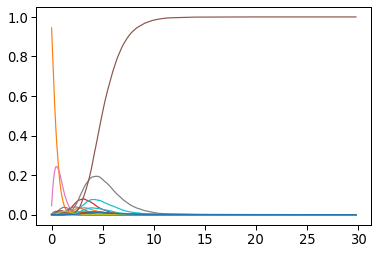

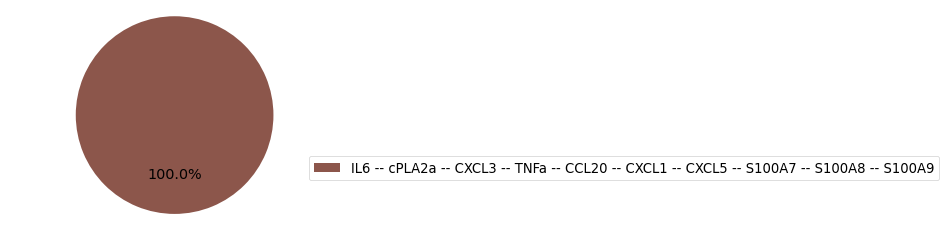

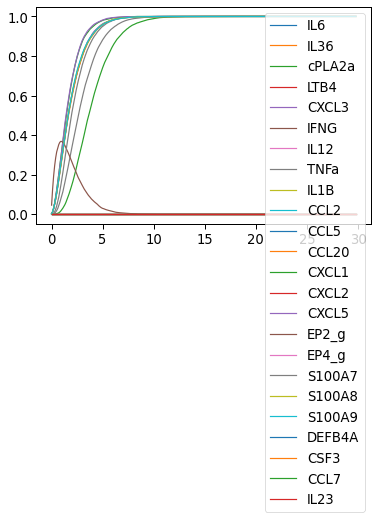

In [18]:
# Setting the initial conditions
mbs_TH17 = ginsim.to_maboss(gs_model)
mbs_TH17.network.set_istate("IL17R", [0, 1])
mbs_TH17.network.set_istate("IL22R", [0, 1])

# Update parameters and outputs of the model
mbs_TH17.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_TH17, infl_markers)

# Simulations and presentation of the results
res_TH17_infl = mbs_TH17.run()
print("MaBoSS simulation output for inflammation phenotype upon Th17 cytokine stimulation")
res_TH17_infl.plot_trajectory(legend=False)
res_TH17_infl.plot_piechart()
res_TH17_infl.get_nodes_probtraj().plot(legend=True)

MaBoSS simulation output for cell fate phenotype upon Th17 cytokine stimulation


<AxesSubplot:>

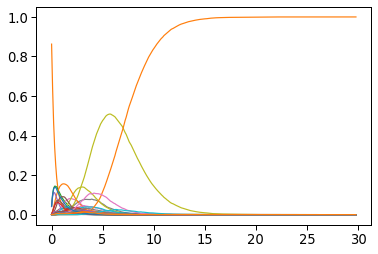

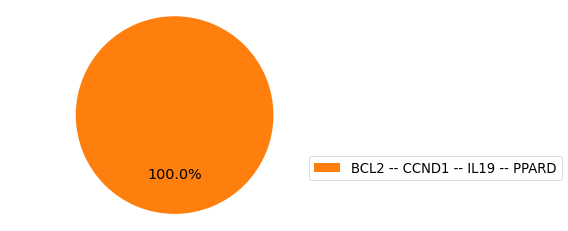

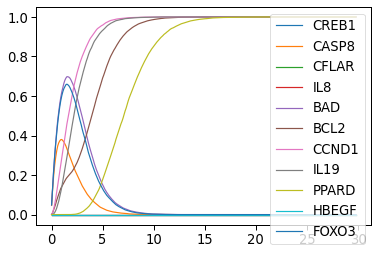

In [19]:
# Setting the initial conditions
mbs_TH17 = ginsim.to_maboss(gs_model)
mbs_TH17.network.set_istate("IL17R", [0, 1])
mbs_TH17.network.set_istate("IL22R", [0, 1])

# Update parameters and outputs of the model
mbs_TH17.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_TH17, fate_markers)
# Simulations and presentation of the results
res_17_fate = mbs_TH17.run()
print("MaBoSS simulation output for cell fate phenotype upon Th17 cytokine stimulation")
res_17_fate.plot_trajectory(legend = False)
res_17_fate.plot_piechart()
res_17_fate.get_nodes_probtraj().plot(legend=True)

MaBoSS simulation output for inflammation phenotype upon Th1 cytokine stimulation


<AxesSubplot:>

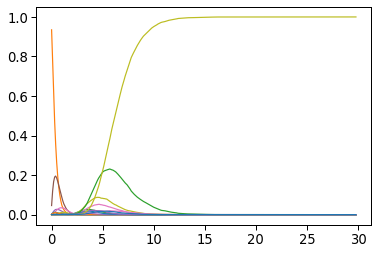

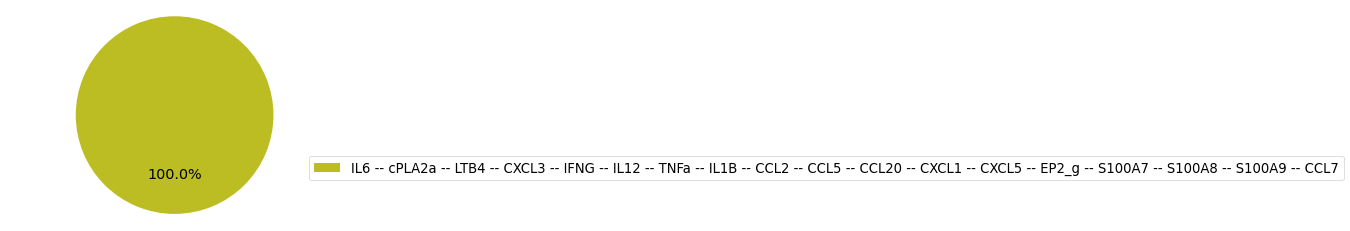

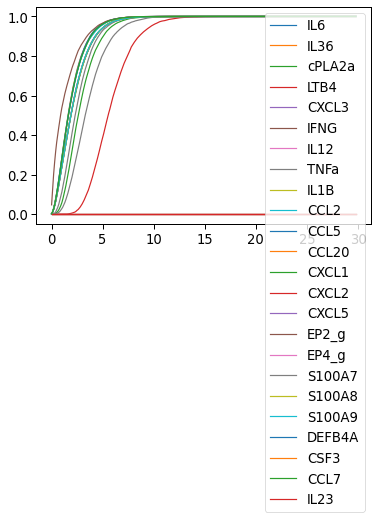

In [20]:
# Setting the initial conditions
mbs_TH1 =  ginsim.to_maboss(gs_model)
mbs_TH1.network.set_istate("TNFRSF1A", [0, 1])
mbs_TH1.network.set_istate("IFNGR", [0, 1])

# Update parameters and outputs of the model
mbs_TH1.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_TH1, infl_markers)

# Simulations and presentation of the results
res_Th1_infl = mbs_TH1.run()
print("MaBoSS simulation output for inflammation phenotype upon Th1 cytokine stimulation")
res_Th1_infl.plot_trajectory(legend=False)
res_Th1_infl.plot_piechart()
res_Th1_infl.get_nodes_probtraj().plot(legend=True)

MaBoSS simulation output for cell fate phenotype upon Th1 cytokine stimulation


<AxesSubplot:>

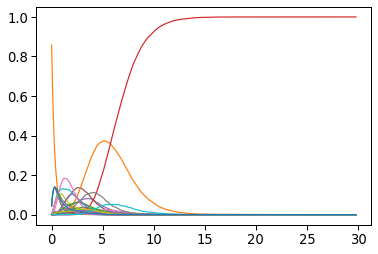

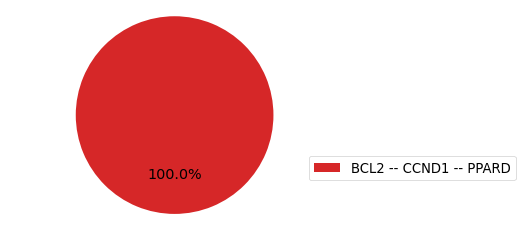

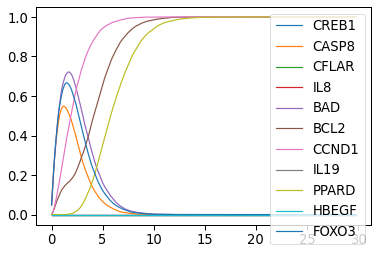

In [21]:
# Setting the initial conditions
mbs_TH1 =  ginsim.to_maboss(gs_model)
mbs_TH1.network.set_istate("TNFRSF1A", [0, 1])
mbs_TH1.network.set_istate("IFNGR", [0, 1])

# Update parameters and outputs of the model
mbs_TH1.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_TH1, fate_markers)

# Simulations and presentation of the results
res_Th1_fate = mbs_TH1.run()
print("MaBoSS simulation output for cell fate phenotype upon Th1 cytokine stimulation")
res_Th1_fate.plot_trajectory(legend = False)
res_Th1_fate.plot_piechart()
res_Th1_fate.get_nodes_probtraj().plot(legend=True)

MaBoSS simulation output for inflammation phenotype in psoriatic conditions


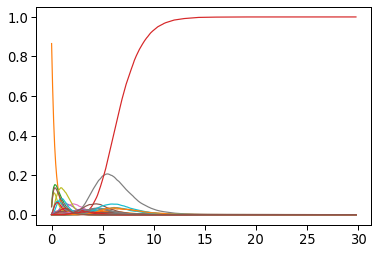

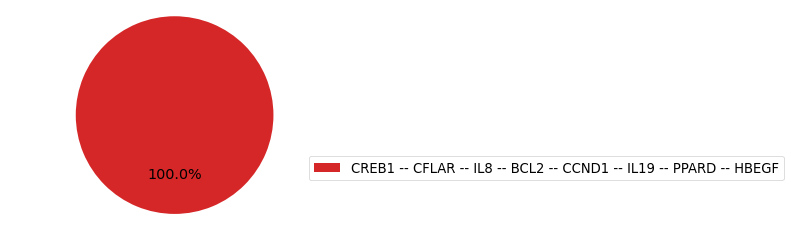

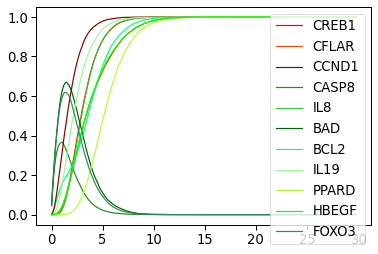

In [22]:
# Setting the initial conditions
mbs_ALL =  ginsim.to_maboss(gs_model)
mbs_ALL.network.set_istate("IL17R", [0, 1])
mbs_ALL.network.set_istate("IL22R", [0, 1])
mbs_ALL.network.set_istate("TNFRSF1A", [0, 1])
mbs_ALL.network.set_istate("IFNGR", [0, 1])
mbs_ALL.network.set_istate("EP4", [0, 1])

# Update parameters and outputs of the model
mbs_ALL.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_ALL, fate_markers)
# Simulations and presentation of the results
res_all_fate = mbs_ALL.run()
print("MaBoSS simulation output for inflammation phenotype in psoriatic conditions")
res_all_fate.plot_trajectory(legend = False)
res_all_fate.plot_piechart()

colors = ['red', 'forestgreen', 'orangered', 'limegreen','darkgreen','springgreen','darkred','palegreen','greenyellow','lime','seagreen','mediumspringgreen','lightgreen','dodgerblue']
p2 =res_all_fate.get_nodes_probtraj().plot(legend=True,color= colors)
handles,labels = p2.get_legend_handles_labels()
order = [0,2,6,1,3,4,5,7,8,9,10]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

MaBoSS simulation output for cell fate phenotype after calcipotriol treatment


<AxesSubplot:>

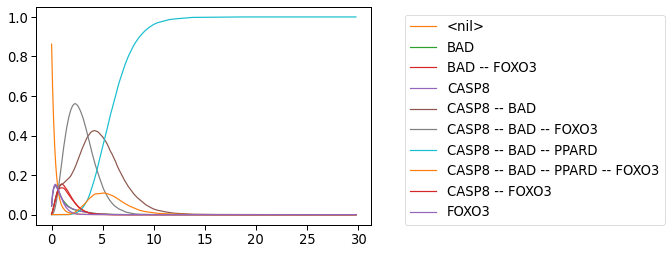

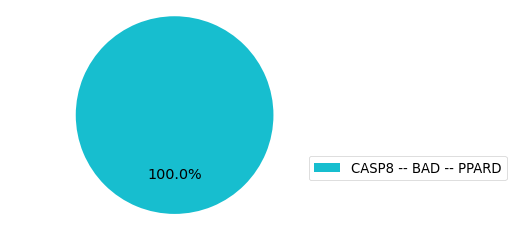

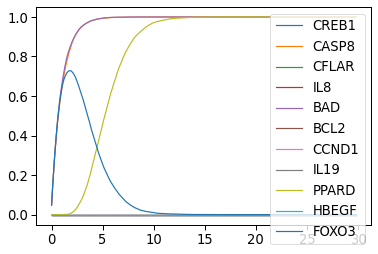

In [23]:
# Setting the initial conditions
mbs_ALL_CAL =  ginsim.to_maboss(gs_model)
mbs_ALL_CAL.network.set_istate("IL17R", [0, 1])
mbs_ALL_CAL.network.set_istate("IL22R", [0, 1])
mbs_ALL_CAL.network.set_istate("TNFRSF1A", [0, 1])
mbs_ALL_CAL.network.set_istate("IFNGR", [0, 1])
mbs_ALL_CAL.mutate("VDR","ON")

# Update parameters and outputs of the model
mbs_ALL_CAL.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_ALL_CAL, fate_markers)

# Simulations and presentation of the results
res_CAL_fate = mbs_ALL_CAL.run()
print("MaBoSS simulation output for cell fate phenotype after calcipotriol treatment")
res_CAL_fate.plot_trajectory(legend = True)
res_CAL_fate.plot_piechart()
res_CAL_fate.get_nodes_probtraj().plot(legend=True)

MaBoSS simulation output for inflammation phenotype after cpla2 inhibition treatment


<AxesSubplot:>

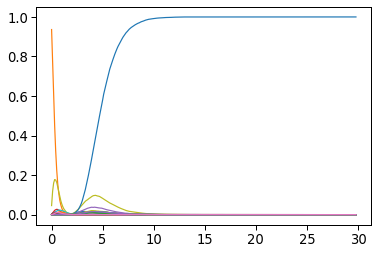

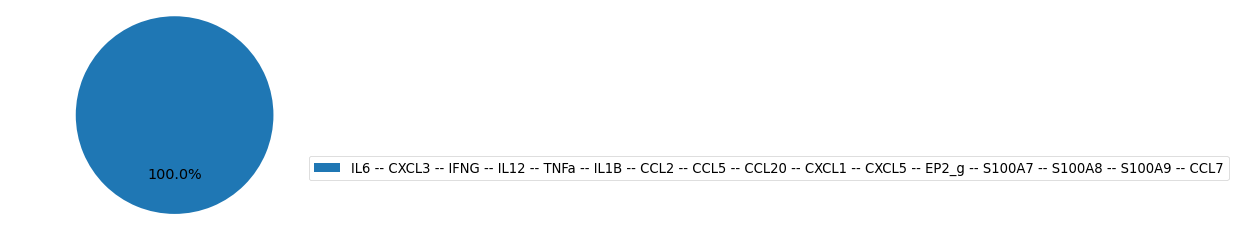

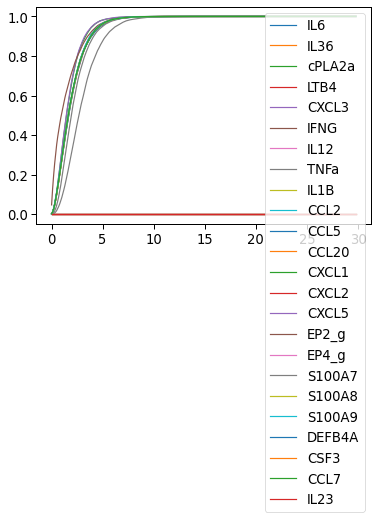

In [24]:
# Setting the initial conditions
mbs_ALL_AVX = ginsim.to_maboss(gs_model)
mbs_ALL_AVX.network.set_istate("IL17R", [0, 1])
mbs_ALL_AVX.network.set_istate("IL22R", [0, 1])
mbs_ALL_AVX.network.set_istate("TNFRSF1A", [0, 1])
mbs_ALL_AVX.network.set_istate("IFNGR", [0, 1])
mbs_ALL_AVX.mutate("EP4","OFF")
mbs_ALL_AVX.mutate("cPLA2a","OFF")

# Setting the initial conditions
mbs_ALL_AVX.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_ALL_AVX, infl_markers)

# Simulations and presentation of the results
res_all_AVX_infl = mbs_ALL_AVX.run()
print("MaBoSS simulation output for inflammation phenotype after cpla2 inhibition treatment")
res_all_AVX_infl.plot_trajectory(legend = False)
res_all_AVX_infl.plot_piechart()
res_all_AVX_infl.get_nodes_probtraj().plot(legend = True)

Figure MaBoSS simulation output for inflammation phenotype when all cytokines are present:


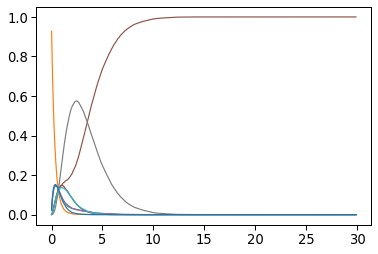

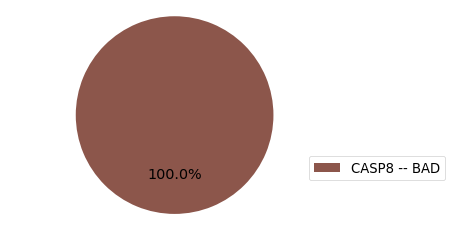

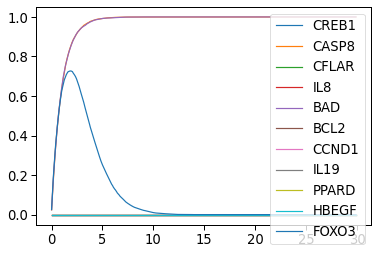

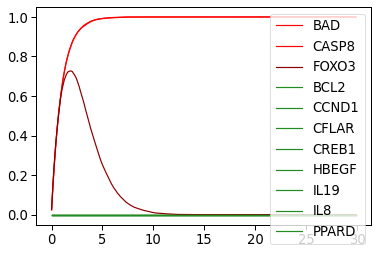

In [25]:
# Setting the initial conditions
mbs_ALL_COM = ginsim.to_maboss(gs_model)
mbs_ALL_COM.network.set_istate("IL17R", [0, 1])
mbs_ALL_COM.network.set_istate("IL22R", [0, 1])
mbs_ALL_COM.network.set_istate("TNFRSF1A", [0, 1])
mbs_ALL_COM.network.set_istate("IFNGR", [0, 1])

mbs_ALL_COM.mutate("VDR","ON")
mbs_ALL_COM.mutate("cPLA2a","OFF")
mbs_ALL_COM.mutate("EP4","OFF")

# Setting the initial conditions
mbs_ALL_COM.update_parameters(sample_count=10000,time_tick=0.05, max_time=30)
maboss.set_output(mbs_ALL_COM, fate_markers)
# Simulations and presentation of the results
res_all_COM_fate = mbs_ALL_COM.run()
print("Figure MaBoSS simulation output for inflammation phenotype when all cytokines are present:")
res_all_COM_fate.plot_trajectory(legend=False)
res_all_COM_fate.plot_piechart()
res_all_COM_fate.get_nodes_probtraj().plot()

colors2 = ['red', 'forestgreen', 'red', 'forestgreen','forestgreen','forestgreen','darkred','forestgreen','forestgreen','forestgreen','forestgreen','forestgreen','forestgreen','forestgreen']

p1 = res_all_COM_fate.get_nodes_probtraj().plot(color=colors2)

handles,labels = p1.get_legend_handles_labels()
order = [0,2,6,1,3,4,5,7,8,9,10]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


## MaBoSS with randomized initial states

MaBoSS simulation output for select cell fate markers after randomizing the initial states


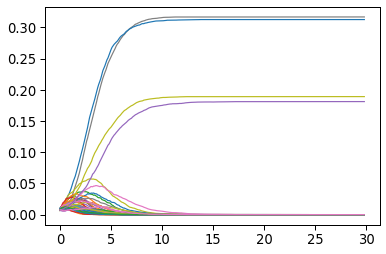

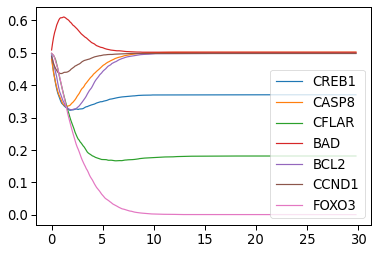

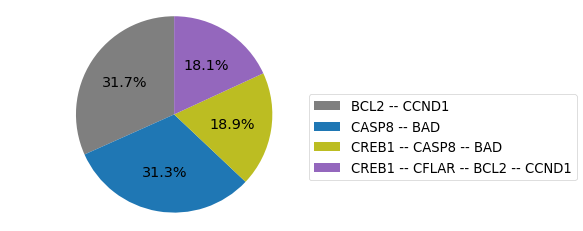

In [26]:
# Setting the initial conditions
mbs_Th17_rand =  ginsim.to_maboss(gs_model)

for n in mbs_Th17_rand.network:
    mbs_Th17_rand.network.set_istate(n,[0.5,0.5])

mbs_Th17_rand.network.set_istate("IL17R", [0, 1])
mbs_Th17_rand.network.set_istate("IL22R", [0, 1])

# Update parameters and outputs of the model
mbs_Th17_rand.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_Th17_rand,['CCND1', 'CFLAR', 'BCL2','CREB1','BAD', 'CASP8','FOXO3'])

# Simulations and presentation of the results
random_Th17_infl = mbs_Th17_rand.run()
print("MaBoSS simulation output for select cell fate markers after randomizing the initial states")
random_Th17_infl.plot_trajectory(legend=False)
random_Th17_infl.get_nodes_probtraj().plot(legend=True)
random_Th17_infl.plot_piechart()

MaBoSS simulation output for select cell fate markers after randomizing the initial states


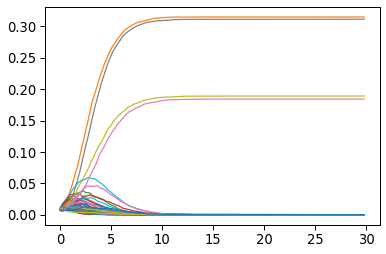

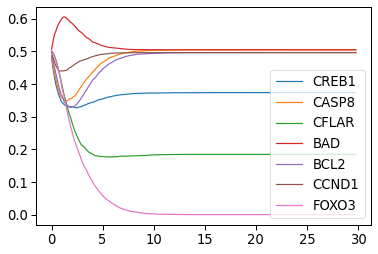

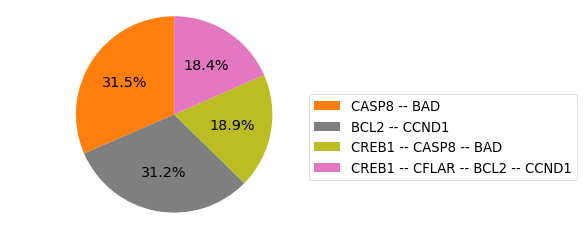

In [27]:
# Setting the initial conditions
mbs_ALL_rand =  ginsim.to_maboss(gs_model)

for n in mbs_ALL_rand.network:
    mbs_ALL_rand.network.set_istate(n,[0.5,0.5])

mbs_ALL_rand.network.set_istate("IL17R", [0, 1])
mbs_ALL_rand.network.set_istate("IL22R", [0, 1])
mbs_ALL_rand.network.set_istate("TNFRSF1A", [0, 1])
mbs_ALL_rand.network.set_istate("IFNGR", [0, 1])

# Update parameters and outputs of the model
mbs_ALL_rand.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_ALL_rand,['CCND1', 'CFLAR', 'BCL2','CREB1','BAD', 'CASP8','FOXO3'])

# Simulations and presentation of the results
random_all_infl = mbs_ALL_rand.run()
print("MaBoSS simulation output for select cell fate markers after randomizing the initial states")
random_all_infl.plot_trajectory(legend=False)
random_all_infl.get_nodes_probtraj().plot(legend=True)
random_all_infl.plot_piechart()

MaBoSS simulation output for select cell fate markers after randomizing the initial states


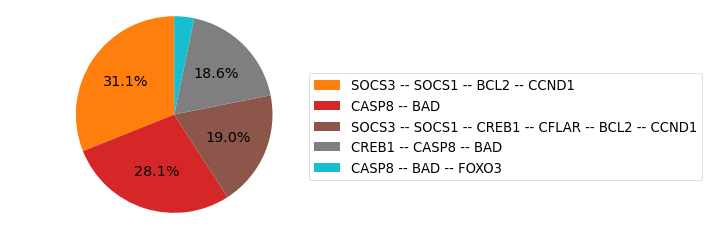

In [28]:
# Setting the initial conditions
mbs_Th1_rand =  ginsim.to_maboss(gs_model)

for n in mbs_Th1_rand.network:
    mbs_Th1_rand.network.set_istate(n,[0.5,0.5])

mbs_Th1_rand.network.set_istate("TNFRSF1A", [0, 1])
mbs_Th1_rand.network.set_istate("IFNGR", [0, 1])

# Update parameters and outputs of the model
mbs_Th1_rand.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_Th1_rand,['CCND1', 'CFLAR', 'BCL2','CREB1','BAD', 'CASP8','FOXO3', 'SOCS1','SOCS3'])

# Simulations and presentation of the results
random_Th1_infl = mbs_Th1_rand.run()
print("MaBoSS simulation output for select cell fate markers after randomizing the initial states")
#random_Th1_infl.plot_trajectory(legend=True)
random_Th1_infl.plot_piechart()
#random_Th1_infl.get_nodes_probtraj().plot(legend=True)

MaBoSS simulation output for select cell fate markers after randomizing the initial states


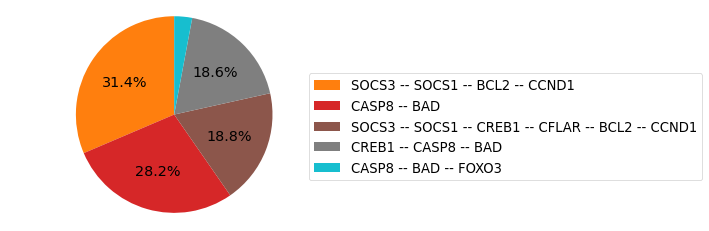

In [29]:
# Setting the initial conditions
mbs_ALL =  ginsim.to_maboss(gs_model)

for n in mbs_ALL.network:
    mbs_ALL.network.set_istate(n,[0.5,0.5])

mbs_ALL.network.set_istate("TNFRSF1A", [0, 1])
mbs_ALL.network.set_istate("IFNGR", [0, 1])

# Update parameters and outputs of the model
mbs_ALL.update_parameters(sample_count=10000,time_tick=0.1, max_time=30)
maboss.set_output(mbs_ALL,['CCND1', 'CFLAR', 'BCL2','CREB1','BAD', 'CASP8','FOXO3', 'SOCS1','SOCS3'])

# Simulations and presentation of the results
random_all_infl = mbs_ALL.run()
print("MaBoSS simulation output for select cell fate markers after randomizing the initial states")
#random_all_infl.plot_trajectory(legend=True)
random_all_infl.plot_piechart()
#random_all_infl.get_nodes_probtraj().plot(legend=True)

## Comparison of the cytokine impact in the model via Value propagation

**NB!** The following functions were taken by the accompaning notebook of the [Computational Verification of Large Logical Models—Application to the Prediction of T Cell Response to Checkpoint Inhibitor](https://www.frontiersin.org/articles/10.3389/fphys.2020.558606/full) paper.

In [30]:
# Transforms a dictionary into a dash-like pattern used for space restrictions.
# If a model has 4 components A, B, C, D in this order,
#  {A:0, D:1} => "0--1"
def dash_pattern(model, dict_vals):
    specific_comps = dict_vals.keys()
    str_pattern = ""
    for comp in model.getComponents():
        if comp.toString() in specific_comps:
            str_pattern += str(dict_vals.get(comp.toString()))
        else :
            str_pattern += "-"
    return(str_pattern)

def restrict_model(model, **dict_vals):
    pattern = dash_pattern(lqm_model, dict_vals)
    return biolqm.restrict(lqm_model, pattern)

def fill_fixed(data, names, functions, mddman):
    all_values = [f for f in functions]
    for comp, func in zip(names, functions):
        if mddman.isleaf(func): data[comp] = func
        else: data[comp] = -1
    

def get_fixed_pattern(all_names, model, as_dict=False):
    # Build a container for the results
    pattern = {key: 100 for key in all_names}
    
    # Model manager and core components
    mddman = model.getMDDManager()
    core_components = [node.getNodeID() for node in model.getComponents()]
    extra_components = [node.getNodeID() for node in model.getExtraComponents()]
    
    # 1/ Non-extra values: if the model was not reduced, core components may also contain fixed values
    fill_fixed(pattern, core_components, model.getLogicalFunctions(), mddman)

    # Special value for input components
    for node in model.getComponents():
        if node.isInput():
            pattern[node.getNodeID()] = -2

    
    # 2/ Extra values : only available after reduction/percolation
    # Functions of each component
    fill_fixed(pattern, extra_components, model.getExtraLogicalFunctions(), mddman)

    if as_dict: return pattern
    return pd.Series(pattern, dtype=np.byte).values.tobytes()

def compare_fixed_pattern(all_names, model1, model2, as_dict=False):
    pattern1 = get_fixed_pattern(all_names, model1, as_dict=True)
    pattern2 = get_fixed_pattern(all_names, model2, as_dict=True)
    
    pattern = {}
    for c in pattern1:
        v1 = pattern1[c]
        v2 = pattern2[c]
        
        if v1 == v2: pattern[c] = v1
        elif v1 < 0: pattern[c] = 10 + v2
        elif v2 < 0: pattern[c] = 20 + v1
        else: pattern[c] = 100

    if as_dict: return pattern
    return pd.Series(pattern, dtype=np.byte).values.tobytes()


def show_fixed_comparison(gs_model, restricted_model1, restricted_model2, styler):
    name_components = [ n.getId() for n in gs_model.getNodeOrder() ]
    pattern = compare_fixed_pattern(name_components, restricted_model1, restricted_model2)
    styler.setState( pattern )
    return ginsim.show(gs_model, style=styler)    


def show_fixed(gs_model, restricted_model, styler):
    name_components = [ n.getId() for n in gs_model.getNodeOrder() ]
    fixed_pattern = get_fixed_pattern(name_components, restricted_model)
    styler.setState(fixed_pattern)
    return ginsim.show(gs_model, style=styler)


# Define color mapping rules

# Style for a single fixed pattern
styler_fixed = ginsim.lrg_style(gs_model)
styler_fixed.mapState2Color(0, 200, 25, 25) # OFF: red
styler_fixed.mapState2Color(1, 100, 175, 100) # ON: green
styler_fixed.mapState2Color(2, 100, 225, 100) # HIGH: bright green
styler_fixed.mapState2Color(-1, 255, 255, 255) # white
styler_fixed.mapState2Color(-2, 175, 175, 175) # gray


# Style for comparing two patterns
styler_comp = ginsim.lrg_style(gs_model)
styler_comp.mapState2Color(-2, 175, 175, 175) # INPUT: gray
styler_comp.mapState2Color(0, 255, 255, 180)  # OFF  in both: light yellow
styler_comp.mapState2Color(1, 255, 180, 120)  # ON   in both: light orange
styler_comp.mapState2Color(2, 255, 180, 120)  # HIGH in both: light orange
styler_comp.mapState2Color(-1, 255, 255, 255) # FREE in both: white
styler_comp.mapState2Color(10, 200, 255, 200) # OFF in the first: light green
styler_comp.mapState2Color(11, 125, 200, 125) # ON  in the first: dark green
styler_comp.mapState2Color(20, 200, 200, 255) # OFF in the second: light purple
styler_comp.mapState2Color(21, 125, 125, 200) # ON  in the second: dark purple
styler_comp.mapState2Color(100, 255, 180, 180) # Other (different values?): red

Propagate values with individual or combinations of psoriatic receptors as a starting nodes


In [31]:
lqm_model_restricted_IL22R = restrict_model(lqm_model, IL22R=1, VDR = 0)
#show_fixed(gs_model, lqm_model_restricted_IL22R, styler_fixed)

lqm_model_restricted_IL17R = restrict_model(lqm_model, IL17R=1, VDR = 0)
#show_fixed(gs_model, lqm_model_restricted_IL17R, styler_fixed)

lqm_model_restricted_IFNGR = restrict_model(lqm_model, IFNGR=1, VDR = 0)
#show_fixed(gs_model, lqm_model_restricted_IFNGR, styler_fixed)

lqm_model_restricted_TNFRSF1A = restrict_model(lqm_model, TNFRSF1A=1, VDR = 0)
#show_fixed(gs_model, lqm_model_restricted_TNFRSF1A, styler_fixed)

lqm_model_restricted_Th1 = restrict_model(lqm_model, TNFRSF1A=1, IFNGR=1, VDR = 0)
#show_fixed(gs_model, lqm_model_restricted_Th1, styler_fixed)

lqm_model_restricted_Th17 = restrict_model(lqm_model, IL17R=1, IL22R=1, VDR = 0)
#show_fixed(gs_model, lqm_model_restricted_Th17, styler_fixed)

lqm_model_restricted_EP4 = restrict_model(lqm_model, EP4 = 1, VDR = 0)
#show_fixed(gs_model, lqm_model_restricted_EP4, styler_fixed)

lqm_model_restricted_ALL = restrict_model(lqm_model, IL17R=1, IL22R=1,TNFRSF1A=1, IFNGR=1, VDR = 0)


In [32]:
# Comparison of Th1 cytokines and Th17 cytokines
show_fixed_comparison(gs_model, lqm_model_restricted_Th1, lqm_model_restricted_Th17, styler_comp)

In [33]:
# Comparison of IFNg and TNFa
show_fixed_comparison(gs_model, lqm_model_restricted_IFNGR, lqm_model_restricted_TNFRSF1A, styler_comp)

In [34]:
# Comparison of IL22 and IL17
show_fixed_comparison(gs_model, lqm_model_restricted_IL22R, lqm_model_restricted_IL17R, styler_comp)

#### Visualize value propagation results as tables

In [35]:
import re

# ID of each component
name_components = [comp.getNodeID() for comp in lqm_model.getComponents()]

tokeep = [name for name in name_components if name in markers]

# Get values after propagation
patternTh1 = get_fixed_pattern(name_components, lqm_model_restricted_Th1, as_dict=True)
patternTh17 = get_fixed_pattern(name_components, lqm_model_restricted_Th17, as_dict=True)

# Compare both patterns
compare_pattern = compare_fixed_pattern(name_components, lqm_model_restricted_Th1, lqm_model_restricted_Th17, as_dict=True)

# Filter out fixed values and inputs (see above)
valuesTh1 = [v for k,v in patternTh1.items() if k in tokeep]
valuesTh17 = [v for k,v in patternTh17.items() if k in tokeep]
valuesBoth = [v for k,v in compare_pattern.items() if k in tokeep]

# Compute values for Table 2
data = {'Impact of value propagation':  ['Frozen inactive nodes', 'Frozen active nodes', 'Free nodes'],
        'TH1 ON': [
            sum([val == 0 for val in valuesTh1]),
            sum([val > 0 for val in valuesTh1]),
            sum([val == -1 for val in valuesTh1]),
        ],
        'TH17/22 ON': [
            sum([val == 0 for val in valuesTh17]),
            sum([val > 0 for val in valuesTh17]),
            sum([val == -1 for val in valuesTh17]),
        ],
        'Intersection': [
            sum([val == 0 for val in valuesBoth]),
            sum([0 < val < 10 for val in valuesBoth]),
            sum([val == -1 for val in valuesBoth]),
        ]}
df = pd.DataFrame(data, columns = ['Impact of value propagation','TH1 ON','TH17/22 ON','Intersection'])
df

,Impact of value propagation,TH1 ON,TH17/22 ON,Intersection
0,Frozen inactive nodes,5,6,4
1,Frozen active nodes,22,15,13
2,Free nodes,14,20,10


In [36]:
# ID of each component
name_components = [comp.getNodeID() for comp in lqm_model.getComponents()]

tokeep = [name for name in name_components if name in markers]

# Get values after propagation
patternIL22 = get_fixed_pattern(name_components, lqm_model_restricted_IL22R, as_dict=True)
patternIL17 = get_fixed_pattern(name_components, lqm_model_restricted_IL17R, as_dict=True)

# Compare both patterns
compare_pattern = compare_fixed_pattern(name_components, lqm_model_restricted_IL22R, lqm_model_restricted_IL17R, as_dict=True)

# Filter out fixed values and inputs (see above)
valuesIL22 = [v for k,v in patternIL22.items() if k in tokeep]
valuesIL17 = [v for k,v in patternIL17.items() if k in tokeep]
valuesBoth = [v for k,v in compare_pattern.items() if k in tokeep]

# Compute values for Table 2
data = {'Impact of value propagation':  ['Frozen inactive nodes', 'Frozen active nodes', 'Free nodes'],
        'IL22 ON': [
            sum([val == 0 for val in valuesIL22]),
            sum([val > 0 for val in valuesIL22]),
            sum([val == -1 for val in valuesIL22]),
        ],
        'IL17 ON': [
            sum([val == 0 for val in valuesIL17]),
            sum([val > 0 for val in valuesIL17]),
            sum([val == -1 for val in valuesIL17]),
        ],
        'Intersection': [
            sum([val == 0 for val in valuesBoth]),
            sum([0 < val < 10 for val in valuesBoth]),
            sum([val == -1 for val in valuesBoth]),
        ]}
df = pd.DataFrame(data, columns = ['Impact of value propagation','IL22 ON','IL17 ON','Intersection'])
df

,Impact of value propagation,IL22 ON,IL17 ON,Intersection
0,Frozen inactive nodes,6,4,4
1,Frozen active nodes,11,15,11
2,Free nodes,24,22,20


In [37]:
# ID of each component
name_components = [comp.getNodeID() for comp in lqm_model.getComponents()]

tokeep = [name for name in name_components if name in markers]

# Get values after propagation
patternIFNg = get_fixed_pattern(name_components, lqm_model_restricted_IFNGR, as_dict=True)
patternTNFa = get_fixed_pattern(name_components, lqm_model_restricted_TNFRSF1A, as_dict=True)

# Compare both patterns
compare_pattern = compare_fixed_pattern(name_components, lqm_model_restricted_IFNGR, lqm_model_restricted_TNFRSF1A, as_dict=True)

# Filter out fixed values and inputs (see above)
valuesIFNg = [v for k,v in patternIFNg.items() if k in tokeep]
valuesTNFa = [v for k,v in patternTNFa.items() if k in tokeep]
valuesBoth = [v for k,v in compare_pattern.items() if k in tokeep]

# Compute values for Table 2
data = {'Impact of value propagation':  ['Frozen inactive nodes', 'Frozen active nodes', 'Free nodes'],
        'Only IFNg ON': [
            sum([val == 0 for val in valuesIFNg]),
            sum([val > 0 for val in valuesIFNg]),
            sum([val == -1 for val in valuesIFNg]),
        ],
        'Only TNFa ON': [
            sum([val == 0 for val in valuesTNFa]),
            sum([val > 0 for val in valuesTNFa]),
            sum([val == -1 for val in valuesTNFa]),
        ],
        'Intersection': [
            sum([val == 0 for val in valuesBoth]),
            sum([0 < val < 10 for val in valuesBoth]),
            sum([val == -1 for val in valuesBoth]),
        ]}
df = pd.DataFrame(data, columns = ['Impact of value propagation','Only IFNg ON','Only TNFa ON','Intersection'])
df

,Impact of value propagation,Only IFNg ON,Only TNFa ON,Intersection
0,Frozen inactive nodes,5,4,4
1,Frozen active nodes,22,11,11
2,Free nodes,14,26,14


## Mutation combination prediction with PINT

The single or double, activating or inhibiting, perturbations that would set the markers in a state that corresponds to a normal phenotype of keratinocytes were predicted wih PINT. The predictions were performed separately of each marker and then the frequency that a perturbation was proposed for any of the markers was counted. The frequency of a perturbation corresponds, therefore, to the number of markers whose state would be "normalized" in response to this specific perturbation.

In [38]:
# Define goals of interest
pint_markers = ['TRAF3IP2=1', 'BAD=0', 'CASP8=0', 'CFLAR=1', 'BCL2=1','FOXO3=0', 'CCND1=1', 'IL8=1', 'IL19=1', 'PGE2=1', 'HETE12=1', 'PPARD=1', 'HBEGF=1', 'FLG=0', 'KRT1=0', 'CALML5=0', 'SIRT1=1', 'CDKN1A=1', 'IL6=1', 'CCL7=1', 'CXCL1=1', 'CXCL2=1', 'CXCL5=1', 'LTB4=1', 'CSF3=1', 'S100A7=1', 'S100A8=1', 'S100A9=1', 'DEFB4A=1', 'EP2_g=1', 'EP4_g=1', 'CXCL3=1', 'IFNG=1', 'IL12=1', 'IL23=1', 'IL36=1', 'IL1B=1', 'TNFa=1', 'CCL2=1', 'CCL5=1', 'CCL20=1']
pint_infl = ['IL6=1', 'CCL7=1', 'CXCL1=1', 'CXCL2=1', 'CXCL5=1', 'LTB4=1', 'CSF3=1', 'S100A7=1', 'S100A8=1', 'S100A9=1', 'DEFB4A=1', 'EP2_g=1', 'EP4_g=1', 'CXCL3=1', 'IFNG=1', 'IL12=1', 'IL23=1', 'IL36=1', 'IL1B=1', 'TNFa=1', 'CCL2=1', 'CCL5=1', 'CCL20=1']
pint_fate = ['TRAF3IP2=1', 'BAD=0', 'CASP8=0', 'CFLAR=1', 'BCL2=1','FOXO3=0', 'CCND1=1', 'IL8=1', 'IL19=1', 'PGE2=1', 'HETE12=1', 'PPARD=1', 'HBEGF=1', 'FLG=0', 'KRT1=0', 'CALML5=0', 'SIRT1=1', 'CDKN1A=1']

In [39]:
%%capture
pint_mutations = []
n = pint_model.having({"IL22R":1,"IL17R":1,"TNFRSF1A":1,"IFNGR":1, "EP4":1,"EP2":1,"EP3":0,"EP1":0 })

for g in pint_markers:
    mutations = list(n.oneshot_mutations_for_cut(g, maxsize=2))
    pint_mutations.extend(mutations)

In [40]:
import collections   
        
count = collections.Counter(tuple(sorted(x.items())) for x in pint_mutations)

combo_count = pd.DataFrame(list(count.items()),columns = ['Combo', 'Frequency'])
combo_count.sort_values(by=['Frequency'], ascending= False)

,Combo,Frequency
18,"((VDR, 1),)",10
4,"((PRKACA, 0),)",9
5,"((EP3, 1),)",9
6,"((EP2, 0), (EP4, 0))",9
2,"((NFKBIA, 1),)",8
3,"((NFKB, 0),)",8
1,"((IKBKB, 0),)",8
15,"((PRKACA, 0), (VDR, 1))",6
33,"((STAT3, 0),)",6
17,"((EP3, 1), (VDR, 1))",6
